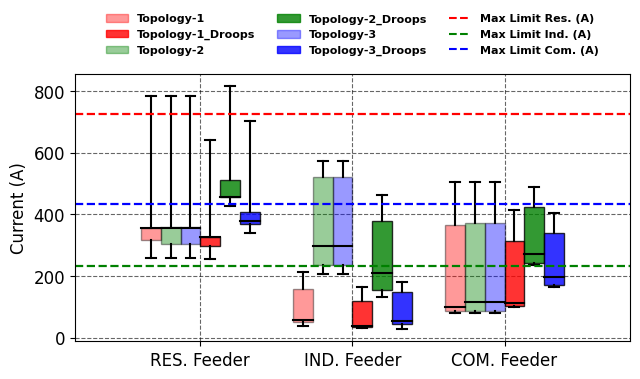

In [1]:
### currents of each feeder at phase-0 --- case-3 --- ########
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from matplotlib.colors import to_rgba

# Define parameters
selected_feeders = ['R01', 'I01', 'C01']  # Feeders to include
selected_phase = 0  # Phase to filter by (0 is A, 1 is B and 2 is C) three-phases

# Feeder name mapping
feeder_names = {
    'R01': 'RES. Feeder',
    'I01': 'IND. Feeder',
    'C01': 'COM. Feeder'
}

# Updated topology colors with same base colors for Droop and non-Droop
topology_colors = {
    'Topology-1': 'red', 'Topology-2': 'green', 'Topology-3': 'blue',
    'Topology-1_Droops': 'red', 'Topology-2_Droops': 'green', 'Topology-3_Droops': 'blue'
}

# Reordered file names to process Without_Droop first
file_names = [
    'current_Without_Droop_T1_case3.csv', 'current_Without_Droop_T2_case3.csv', 'current_Without_Droop_T3_case3.csv',
    'current_With_Droop_T1_case3.csv', 'current_With_Droop_T2_case3.csv', 'current_With_Droop_T3_case3.csv'
]

# Function to read and process current data (unchanged)
def process_current_data(file_path, selected_feeders, selected_phase):
    try:
        df = pd.read_csv(file_path)
        df = df.dropna(subset=['Bus', 'Current (A)'])
        df['Current (A)'] = pd.to_numeric(df['Current (A)'], errors='coerce')
        df = df.dropna(subset=['Current (A)'])

        filtered_data = {feeder: [] for feeder in selected_feeders}
        for feeder in selected_feeders:
            feeder_data = df[(df['Bus'] == feeder) & (df['Phase'] == selected_phase)]['Current (A)'].values
            if len(feeder_data) > 0:
                filtered_data[feeder] = feeder_data
        return filtered_data
    except FileNotFoundError:
        print(f"Error: File '{file_path}' not found.")
        return None
    except pd.errors.EmptyDataError:
        print(f"Error: File '{file_path}' is empty.")
        return None
    except Exception as e:
        print(f"An unexpected error occurred while processing '{file_path}': {e}")
        return None

# Read and process all CSV files (unchanged)
all_current_data = {}
for file_name in file_names:
    data = process_current_data(file_name, selected_feeders, selected_phase)
    if data:
        scenario_name = file_name.replace('.csv', '').replace('current_', '')
        all_current_data[scenario_name] = data

# Prepare data for box plot (unchanged)
box_plot_data = {}
for scenario, data in all_current_data.items():
    for feeder, currents in data.items():
        if feeder not in box_plot_data:
            box_plot_data[feeder] = {}
        box_plot_data[feeder][scenario] = currents

scenario_mapping = {
    'With_Droop_T1_case3': 'Topology-1_Droops',
    'With_Droop_T2_case3': 'Topology-2_Droops',
    'With_Droop_T3_case3': 'Topology-3_Droops',
    'Without_Droop_T1_case3': 'Topology-1',
    'Without_Droop_T2_case3': 'Topology-2',
    'Without_Droop_T3_case3': 'Topology-3'
}

# Create box plot
fig, ax = plt.subplots(figsize=(6.5, 4))

handles = []
labels = []
width = 0.13

positions = np.arange(len(selected_feeders))

for i, feeder in enumerate(selected_feeders):
    bus_positions = positions[i] + np.arange(len(box_plot_data[feeder])) * width
    for j, (scenario, currents) in enumerate(box_plot_data[feeder].items()):
        mapped_scenario = scenario_mapping.get(scenario)
        color = topology_colors.get(mapped_scenario)
        if color is None:
            print(f"Warning: No color found for scenario '{scenario}'. Using default color.")
            color = 'gray'

        # Set alpha based on Droop status
        alpha = 0.4 if '_Droops' not in mapped_scenario else 0.8

        box = ax.boxplot(currents, positions=[bus_positions[j]], widths=width, patch_artist=True, showfliers=False, whis=100000)

        plt.setp(box['boxes'], color='black', facecolor=color, alpha=alpha)
        plt.setp(box['medians'], color='black', linewidth=1.5)
        plt.setp(box['caps'], color='black', linewidth=1.5)
        plt.setp(box['whiskers'], color='black', linewidth=1.5)

# Create a custom legend with alpha handling
legend_handles = []
legend_labels = []

for scenario in sorted(topology_colors.keys()):
    alpha = 0.4 if '_Droops' not in scenario else 0.8  # Conditional alpha for legend too
    rgba_color = to_rgba(topology_colors[scenario], alpha=alpha)
    handle = mpatches.Patch(color=rgba_color, label=scenario)
    legend_handles.append(handle)
    legend_labels.append(scenario)

# Create the legend using the custom handles and labels
legend = ax.legend(handles=legend_handles, labels=legend_labels, loc='upper center', 
                   bbox_to_anchor=(0.5, 1.15), ncol=3, frameon=False, 
                   prop={'size': 8, 'weight': 'bold'})

# Max current lines (unchanged)
max_currents = {
    'R01': 724,
    'I01': 231,
    'C01': 434
}
colors_lines = {
    'R01': 'red',
    'I01': 'green',
    'C01': 'blue'
}
labels_lines = {
    'R01': 'Max Limit Res. (A)',
    'I01': 'Max Limit Ind. (A)',
    'C01': 'Max Limit Com. (A)'
}

legend_handles_lines = []
legend_labels_lines = []
for feeder, max_current in max_currents.items():
    color = colors_lines[feeder]
    label = labels_lines[feeder]
    line = mlines.Line2D([0], [0], color=color, linestyle='--', label=label)
    ax.axhline(y=max_current, color=color, linestyle='--', linewidth=1.6)
    legend_handles_lines.append(line)
    legend_labels_lines.append(label)

# Combine legends
legend_handles_combined = legend_handles + legend_handles_lines
legend_labels_combined = legend_labels + legend_labels_lines

# Create combined legend
legend = ax.legend(handles=legend_handles_combined, labels=legend_labels_combined, 
                   loc='upper center', bbox_to_anchor=(0.5, 1.26), ncol=3, 
                   frameon=False, prop={'size': 8, 'weight': 'bold'})

ax.set_xticks(positions + width * (len(box_plot_data[selected_feeders[0]]) - 1) / 2)
ax.set_xticklabels([feeder_names[feeder] for feeder in selected_feeders], fontsize=12)
ax.set_ylabel('Current (A)', fontsize=12)
ax.tick_params(axis='y', labelsize=12)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontweight('normal')
ax.grid(linestyle='--', color='black', alpha=0.6)
plt.tight_layout()
plt.show()

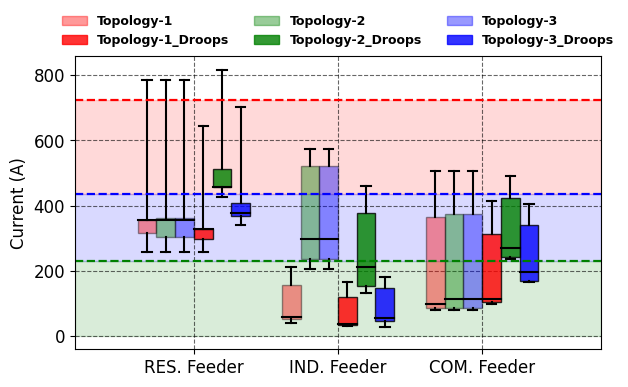

In [2]:
### currents of each feeder at phase-0 --- case-3 --- ######## Shaded zones fig.13
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from matplotlib.colors import to_rgba

# Define parameters
selected_feeders = ['R01', 'I01', 'C01']  # Feeders to include
selected_phase = 0  # Phase to filter by (0 is A, 1 is B and 2 is C) three-phases

# Feeder name mapping
feeder_names = {
    'R01': 'RES. Feeder',
    'I01': 'IND. Feeder',
    'C01': 'COM. Feeder'
}

# Updated topology colors with same base colors for Droop and non-Droop
topology_colors = {
    'Topology-1': 'red', 'Topology-2': 'green', 'Topology-3': 'blue',
    'Topology-1_Droops': 'red', 'Topology-2_Droops': 'green', 'Topology-3_Droops': 'blue'
}

# Reordered file names to process Without_Droop first
file_names = [
    'current_Without_Droop_T1_case3.csv', 'current_Without_Droop_T2_case3.csv', 'current_Without_Droop_T3_case3.csv',
    'current_With_Droop_T1_case3.csv', 'current_With_Droop_T2_case3.csv', 'current_With_Droop_T3_case3.csv'
]

# Function to read and process current data
def process_current_data(file_path, selected_feeders, selected_phase):
    try:
        df = pd.read_csv(file_path)
        df = df.dropna(subset=['Bus', 'Current (A)'])
        df['Current (A)'] = pd.to_numeric(df['Current (A)'], errors='coerce')
        df = df.dropna(subset=['Current (A)'])

        filtered_data = {feeder: [] for feeder in selected_feeders}
        for feeder in selected_feeders:
            feeder_data = df[(df['Bus'] == feeder) & (df['Phase'] == selected_phase)]['Current (A)'].values
            if len(feeder_data) > 0:
                filtered_data[feeder] = feeder_data
        return filtered_data
    except FileNotFoundError:
        print(f"Error: File '{file_path}' not found.")
        return None
    except pd.errors.EmptyDataError:
        print(f"Error: File '{file_path}' is empty.")
        return None
    except Exception as e:
        print(f"An unexpected error occurred while processing '{file_path}': {e}")
        return None

# Read and process all CSV files
all_current_data = {}
for file_name in file_names:
    data = process_current_data(file_name, selected_feeders, selected_phase)
    if data:
        scenario_name = file_name.replace('.csv', '').replace('current_', '')
        all_current_data[scenario_name] = data

# Prepare data for box plot
box_plot_data = {}
for scenario, data in all_current_data.items():
    for feeder, currents in data.items():
        if feeder not in box_plot_data:
            box_plot_data[feeder] = {}
        box_plot_data[feeder][scenario] = currents

scenario_mapping = {
    'With_Droop_T1_case3': 'Topology-1_Droops',
    'With_Droop_T2_case3': 'Topology-2_Droops',
    'With_Droop_T3_case3': 'Topology-3_Droops',
    'Without_Droop_T1_case3': 'Topology-1',
    'Without_Droop_T2_case3': 'Topology-2',
    'Without_Droop_T3_case3': 'Topology-3'
}

# Create box plot
fig, ax = plt.subplots(figsize=(6.5, 4))

handles = []
labels = []
width = 0.13

positions = np.arange(len(selected_feeders))

for i, feeder in enumerate(selected_feeders):
    bus_positions = positions[i] + np.arange(len(box_plot_data[feeder])) * width
    for j, (scenario, currents) in enumerate(box_plot_data[feeder].items()):
        mapped_scenario = scenario_mapping.get(scenario)
        color = topology_colors.get(mapped_scenario)
        if color is None:
            print(f"Warning: No color found for scenario '{scenario}'. Using default color.")
            color = 'gray'

        # Set alpha based on Droop status
        alpha = 0.4 if '_Droops' not in mapped_scenario else 0.8

        box = ax.boxplot(currents, positions=[bus_positions[j]], widths=width, patch_artist=True, showfliers=False, whis=100000)

        plt.setp(box['boxes'], color='black', facecolor=color, alpha=alpha)
        plt.setp(box['medians'], color='black', linewidth=1.5)
        plt.setp(box['caps'], color='black', linewidth=1.5)
        plt.setp(box['whiskers'], color='black', linewidth=1.5)

# Shade the zones
shading_ranges = {
    'R01': (434, 724),  # From 434 to 724
    'I01': (0, 231),    # From 0 (bottom) to 231
    'C01': (231, 434)   # From 231 to 434
}

shading_colors = {
    'R01': 'red',
    'I01': 'green',
    'C01': 'blue'
}

for feeder, (start, end) in shading_ranges.items():
    color = shading_colors[feeder]
    ax.fill_between(ax.get_xlim(), start, end, color=color, alpha=0.15) ## alpha of the shaded zones

# Create a custom legend with alpha handling
legend_handles = []
legend_labels = []

for scenario in sorted(topology_colors.keys()):
    alpha = 0.4 if '_Droops' not in scenario else 0.8  # Conditional alpha for legend too
    rgba_color = to_rgba(topology_colors[scenario], alpha=alpha)
    handle = mpatches.Patch(color=rgba_color, label=scenario)
    legend_handles.append(handle)
    legend_labels.append(scenario)

# Create the legend using the custom handles and labels
legend = ax.legend(handles=legend_handles, labels=legend_labels, loc='upper center', 
                   bbox_to_anchor=(0.5, 1.18), ncol=3, frameon=False, 
                   prop={'size': 9, 'weight': 'bold'})

# Max current lines
max_currents = {
    'R01': 724,
    'I01': 231,
    'C01': 434
}
colors_lines = {
    'R01': 'red',
    'I01': 'green',
    'C01': 'blue'
}

# Draw the max current lines without adding them to the legend
for feeder, max_current in max_currents.items():
    color = colors_lines[feeder]
    ax.axhline(y=max_current, color=color, linestyle='--', linewidth=1.6)

ax.set_xticks(positions + width * (len(box_plot_data[selected_feeders[0]]) - 1) / 2)
ax.set_xticklabels([feeder_names[feeder] for feeder in selected_feeders], fontsize=12)
ax.set_ylabel('Current (A)', fontsize=12)
ax.tick_params(axis='y', labelsize=12)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontweight('normal')
ax.grid(linestyle='--', color='black', alpha=0.6)
plt.tight_layout()

# Save the figure with high resolution at the specified path
plt.savefig(r'E:\PhD\New folder\Figures\box\Voltage+Cureent\Current - Copy - Copy\fig.13.png', dpi=400)

plt.show()

In [4]:
# Calculate maximum currents and violations
violation_results = {}

for feeder, currents_dict in box_plot_data.items():
    max_limit = shading_ranges[feeder][1]  # Get upper limit from shading_ranges
    violation_results[feeder] = {}
    
    for scenario, currents in currents_dict.items():
        peak_current = np.max(currents)
        violation_pct = ((peak_current - max_limit) / max_limit) * 100 if peak_current > max_limit else 0
        violation_results[feeder][scenario] = {
            'peak': round(peak_current, 1),
            'violation_pct': round(violation_pct, 1),
            'limit': max_limit
        }

# Convert to DataFrame for LaTeX table
df_violations = pd.DataFrame.from_dict({
    (feeder, scenario): vals 
    for feeder, scenarios in violation_results.items() 
    for scenario, vals in scenarios.items()
}, orient='index')

print(df_violations.to_markdown())  # For copy-pasting into your paper

|                                   |   peak |   violation_pct |   limit |
|:----------------------------------|-------:|----------------:|--------:|
| ('R01', 'Without_Droop_T1_case3') |  785.1 |             8.4 |     724 |
| ('R01', 'Without_Droop_T2_case3') |  785.1 |             8.4 |     724 |
| ('R01', 'Without_Droop_T3_case3') |  785.1 |             8.4 |     724 |
| ('R01', 'With_Droop_T1_case3')    |  642.4 |             0   |     724 |
| ('R01', 'With_Droop_T2_case3')    |  817.2 |            12.9 |     724 |
| ('R01', 'With_Droop_T3_case3')    |  702.2 |             0   |     724 |
| ('I01', 'Without_Droop_T1_case3') |  212.8 |             0   |     231 |
| ('I01', 'Without_Droop_T2_case3') |  573.2 |           148.1 |     231 |
| ('I01', 'Without_Droop_T3_case3') |  573.2 |           148.1 |     231 |
| ('I01', 'With_Droop_T1_case3')    |  163.9 |             0   |     231 |
| ('I01', 'With_Droop_T2_case3')    |  461.3 |            99.7 |     231 |
| ('I01', 'With_Droop_T3_

In [6]:
# Using your exact file list for Case-3
case3_files = [
    'current_Without_Droop_T1_case3.csv',
    'current_Without_Droop_T2_case3.csv',
    'current_Without_Droop_T3_case3.csv',
    'current_With_Droop_T1_case3.csv',
    'current_With_Droop_T2_case3.csv',
    'current_With_Droop_T3_case3.csv'
]

# Reprocess data using only these files
all_current_data_case3 = {}
for file_name in case3_files:
    data = process_current_data(file_name, selected_feeders, selected_phase)
    if data:
        scenario_name = file_name.replace('.csv', '').replace('current_', '')
        all_current_data_case3[scenario_name] = data

# Rebuild box_plot_data for Case-3
box_plot_data_case3 = {}
for scenario, data in all_current_data_case3.items():
    for feeder, currents in data.items():
        if feeder not in box_plot_data_case3:
            box_plot_data_case3[feeder] = {}
        box_plot_data_case3[feeder][scenario] = currents

# Now analyze violations
violation_results = {}
for feeder, currents_dict in box_plot_data_case3.items():
    max_limit = max_currents[feeder]  # From your plotting code
    violation_results[feeder] = {}
    
    for scenario, currents in currents_dict.items():
        peak_current = np.max(currents)
        violation_pct = ((peak_current - max_limit) / max_limit) * 100 if peak_current > max_limit else 0
        violation_results[feeder][scenario] = {
            'peak': round(peak_current, 1),
            'violation_pct': round(violation_pct, 1),
            'limit': max_limit
        }

# Convert to DataFrame
df_violations = pd.DataFrame.from_dict({
    (feeder, scenario): vals 
    for feeder, scenarios in violation_results.items() 
    for scenario, vals in scenarios.items()
}, orient='index')

print("CASE-3 VIOLATION ANALYSIS")
print(df_violations.to_markdown())

CASE-3 VIOLATION ANALYSIS
|                                   |   peak |   violation_pct |   limit |
|:----------------------------------|-------:|----------------:|--------:|
| ('R01', 'Without_Droop_T1_case3') |  785.1 |             8.4 |     724 |
| ('R01', 'Without_Droop_T2_case3') |  785.1 |             8.4 |     724 |
| ('R01', 'Without_Droop_T3_case3') |  785.1 |             8.4 |     724 |
| ('R01', 'With_Droop_T1_case3')    |  642.4 |             0   |     724 |
| ('R01', 'With_Droop_T2_case3')    |  817.2 |            12.9 |     724 |
| ('R01', 'With_Droop_T3_case3')    |  702.2 |             0   |     724 |
| ('I01', 'Without_Droop_T1_case3') |  212.8 |             0   |     231 |
| ('I01', 'Without_Droop_T2_case3') |  573.2 |           148.1 |     231 |
| ('I01', 'Without_Droop_T3_case3') |  573.2 |           148.1 |     231 |
| ('I01', 'With_Droop_T1_case3')    |  163.9 |             0   |     231 |
| ('I01', 'With_Droop_T2_case3')    |  461.3 |            99.7 |     231 |

In [7]:
# Calculate current reduction from Droop control
droop_reduction = {}

for feeder in box_plot_data_case3.keys():
    droop_reduction[feeder] = {}
    
    for topology in ['T1', 'T2', 'T3']:
        # Get without-droop and with-droop scenarios
        without_scenario = f'Without_Droop_{topology}_case3'
        with_scenario = f'With_Droop_{topology}_case3'
        
        # Extract peak currents
        peak_without = np.max(box_plot_data_case3[feeder][without_scenario])
        peak_with = np.max(box_plot_data_case3[feeder][with_scenario])
        
        # Calculate percentage reduction
        reduction = ((peak_without - peak_with) / peak_without) * 100
        
        droop_reduction[feeder][topology] = {
            'without_droop': round(peak_without, 1),
            'with_droop': round(peak_with, 1),
            'reduction_pct': round(reduction, 1)
        }

# Convert to DataFrame
df_reduction = pd.DataFrame.from_dict({
    (feeder, topology): vals 
    for feeder, topologies in droop_reduction.items() 
    for topology, vals in topologies.items()
}, orient='index')

print("DROOP CONTROL CURRENT REDUCTION (CASE-3)")
print(df_reduction.to_markdown())

DROOP CONTROL CURRENT REDUCTION (CASE-3)
|               |   without_droop |   with_droop |   reduction_pct |
|:--------------|----------------:|-------------:|----------------:|
| ('R01', 'T1') |           785.1 |        642.4 |            18.2 |
| ('R01', 'T2') |           785.1 |        817.2 |            -4.1 |
| ('R01', 'T3') |           785.1 |        702.2 |            10.6 |
| ('I01', 'T1') |           212.8 |        163.9 |            22.9 |
| ('I01', 'T2') |           573.2 |        461.3 |            19.5 |
| ('I01', 'T3') |           573.2 |        182.1 |            68.2 |
| ('C01', 'T1') |           504.7 |        413.8 |            18   |
| ('C01', 'T2') |           504.7 |        489.9 |             2.9 |
| ('C01', 'T3') |           504.7 |        405.2 |            19.7 |


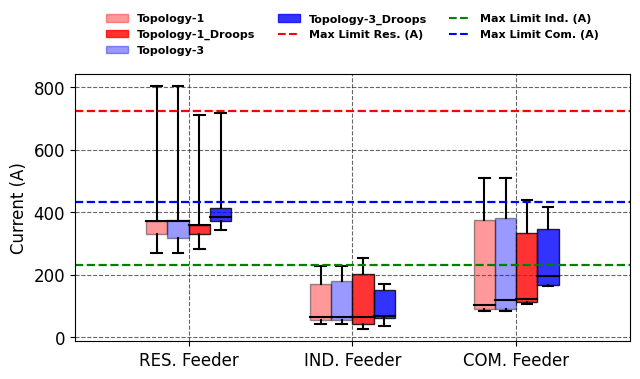

In [2]:
### currents of each feeder at phase-0 --- case-1 --- ########
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from matplotlib.colors import to_rgba

# Define parameters
selected_feeders = ['R01', 'I01', 'C01']  # Feeders to include
selected_phase = 0  # Phase to filter by (0 is A, 1 is B and 2 is C) three-phases

# Feeder name mapping
feeder_names = {
    'R01': 'RES. Feeder',
    'I01': 'IND. Feeder',
    'C01': 'COM. Feeder'
}

# Updated topology colors with same base colors for Droop and non-Droop
topology_colors = {
    'Topology-1': 'red', 'Topology-3': 'blue',
    'Topology-1_Droops': 'red', 'Topology-3_Droops': 'blue'
}

# Reordered file names to process Without_Droop first.  This is crucial for correct plotting.
file_names = [
    'current_Without_Droop_T1_case1.csv', 'current_Without_Droop_T3_case1.csv',
    'current_With_Droop_T1_case1.csv', 'current_With_Droop_T3_case1.csv'
]

# Function to read and process current data (unchanged)
def process_current_data(file_path, selected_feeders, selected_phase):
    try:
        df = pd.read_csv(file_path)
        df = df.dropna(subset=['Bus', 'Current (A)'])
        df['Current (A)'] = pd.to_numeric(df['Current (A)'], errors='coerce')
        df = df.dropna(subset=['Current (A)'])

        filtered_data = {feeder: [] for feeder in selected_feeders}
        for feeder in selected_feeders:
            feeder_data = df[(df['Bus'] == feeder) & (df['Phase'] == selected_phase)]['Current (A)'].values
            if len(feeder_data) > 0:
                filtered_data[feeder] = feeder_data
        return filtered_data
    except FileNotFoundError:
        print(f"Error: File '{file_path}' not found.")
        return None
    except pd.errors.EmptyDataError:
        print(f"Error: File '{file_path}' is empty.")
        return None
    except Exception as e:
        print(f"An unexpected error occurred while processing '{file_path}': {e}")
        return None

# Read and process all CSV files (unchanged)
all_current_data = {}
for file_name in file_names:
    data = process_current_data(file_name, selected_feeders, selected_phase)
    if data:
        scenario_name = file_name.replace('.csv', '').replace('current_', '')
        all_current_data[scenario_name] = data

# Prepare data for box plot (unchanged)
box_plot_data = {}
for scenario, data in all_current_data.items():
    for feeder, currents in data.items():
        if feeder not in box_plot_data:
            box_plot_data[feeder] = {}
        box_plot_data[feeder][scenario] = currents

# CORRECTED scenario_mapping for case1
scenario_mapping = {
    'With_Droop_T1_case1': 'Topology-1_Droops',
    'With_Droop_T3_case1': 'Topology-3_Droops',
    'Without_Droop_T1_case1': 'Topology-1',
    'Without_Droop_T3_case1': 'Topology-3'
}

# Create box plot
fig, ax = plt.subplots(figsize=(6.5, 4))

handles = []
labels = []
width = 0.13

positions = np.arange(len(selected_feeders))

for i, feeder in enumerate(selected_feeders):
    bus_positions = positions[i] + np.arange(len(box_plot_data[feeder])) * width
    for j, (scenario, currents) in enumerate(box_plot_data[feeder].items()):
        mapped_scenario = scenario_mapping.get(scenario)
        color = topology_colors.get(mapped_scenario)
        if color is None:
            print(f"Warning: No color found for scenario '{scenario}'. Using default color.")
            color = 'gray'

        # Set alpha based on Droop status
        alpha = 0.4 if '_Droops' not in mapped_scenario else 0.8

        box = ax.boxplot(currents, positions=[bus_positions[j]], widths=width, patch_artist=True, showfliers=False, whis=100000)

        plt.setp(box['boxes'], color='black', facecolor=color, alpha=alpha)
        plt.setp(box['medians'], color='black', linewidth=1.5)
        plt.setp(box['caps'], color='black', linewidth=1.5)
        plt.setp(box['whiskers'], color='black', linewidth=1.5)

# Create a custom legend with alpha handling
legend_handles = []
legend_labels = []

for scenario in sorted(topology_colors.keys()):
    alpha = 0.4 if '_Droops' not in scenario else 0.8  # Conditional alpha for legend too
    rgba_color = to_rgba(topology_colors[scenario], alpha=alpha)
    handle = mpatches.Patch(color=rgba_color, label=scenario)
    legend_handles.append(handle)
    legend_labels.append(scenario)

# Create the legend using the custom handles and labels
legend = ax.legend(handles=legend_handles, labels=legend_labels, loc='upper center', 
                   bbox_to_anchor=(0.5, 1.15), ncol=3, frameon=False, 
                   prop={'size': 8, 'weight': 'bold'})

# Max current lines (unchanged)
max_currents = {
    'R01': 724,
    'I01': 231,
    'C01': 434
}
colors_lines = {
    'R01': 'red',
    'I01': 'green',
    'C01': 'blue'
}
labels_lines = {
    'R01': 'Max Limit Res. (A)',
    'I01': 'Max Limit Ind. (A)',
    'C01': 'Max Limit Com. (A)'
}

legend_handles_lines = []
legend_labels_lines = []
for feeder, max_current in max_currents.items():
    color = colors_lines[feeder]
    label = labels_lines[feeder]
    line = mlines.Line2D([0], [0], color=color, linestyle='--', label=label)
    ax.axhline(y=max_current, color=color, linestyle='--', linewidth=1.6)
    legend_handles_lines.append(line)
    legend_labels_lines.append(label)

# Combine legends
legend_handles_combined = legend_handles + legend_handles_lines
legend_labels_combined = legend_labels + legend_labels_lines

# Create combined legend
legend = ax.legend(handles=legend_handles_combined, labels=legend_labels_combined, 
                   loc='upper center', bbox_to_anchor=(0.5, 1.26), ncol=3, 
                   frameon=False, prop={'size': 8, 'weight': 'bold'})

ax.set_xticks(positions + width * (len(box_plot_data[selected_feeders[0]]) - 1) / 2)
ax.set_xticklabels([feeder_names[feeder] for feeder in selected_feeders], fontsize=12)
ax.set_ylabel('Current (A)', fontsize=12)
ax.tick_params(axis='y', labelsize=12)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontweight('normal')
ax.grid(linestyle='--', color='black', alpha=0.6)
plt.tight_layout()
plt.show()

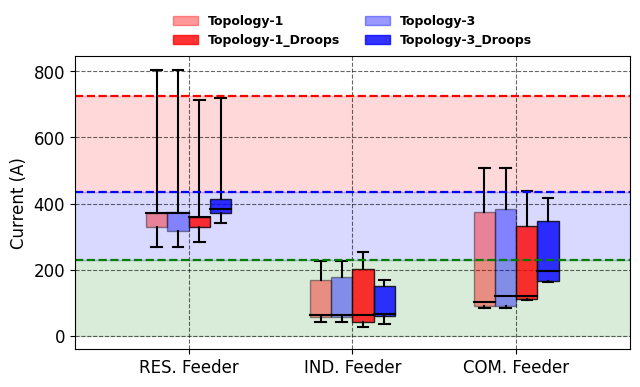

In [9]:
### currents of each feeder at phase-0 --- case-1 --- ######## shaded zones fig.16
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from matplotlib.colors import to_rgba

# Define parameters
selected_feeders = ['R01', 'I01', 'C01']  # Feeders to include
selected_phase = 0  # Phase to filter by (0 is A, 1 is B and 2 is C) three-phases

# Feeder name mapping
feeder_names = {
    'R01': 'RES. Feeder',
    'I01': 'IND. Feeder',
    'C01': 'COM. Feeder'
}

# Updated topology colors with same base colors for Droop and non-Droop
topology_colors = {
    'Topology-1': 'red', 'Topology-3': 'blue',
    'Topology-1_Droops': 'red', 'Topology-3_Droops': 'blue'
}

# Reordered file names to process Without_Droop first.  This is crucial for correct plotting.
file_names = [
    'current_Without_Droop_T1_case1.csv', 'current_Without_Droop_T3_case1.csv',
    'current_With_Droop_T1_case1.csv', 'current_With_Droop_T3_case1.csv'
]

# Function to read and process current data
def process_current_data(file_path, selected_feeders, selected_phase):
    try:
        df = pd.read_csv(file_path)
        df = df.dropna(subset=['Bus', 'Current (A)'])
        df['Current (A)'] = pd.to_numeric(df['Current (A)'], errors='coerce')
        df = df.dropna(subset=['Current (A)'])

        filtered_data = {feeder: [] for feeder in selected_feeders}
        for feeder in selected_feeders:
            feeder_data = df[(df['Bus'] == feeder) & (df['Phase'] == selected_phase)]['Current (A)'].values
            if len(feeder_data) > 0:
                filtered_data[feeder] = feeder_data
        return filtered_data
    except FileNotFoundError:
        print(f"Error: File '{file_path}' not found.")
        return None
    except pd.errors.EmptyDataError:
        print(f"Error: File '{file_path}' is empty.")
        return None
    except Exception as e:
        print(f"An unexpected error occurred while processing '{file_path}': {e}")
        return None

# Read and process all CSV files
all_current_data = {}
for file_name in file_names:
    data = process_current_data(file_name, selected_feeders, selected_phase)
    if data:
        scenario_name = file_name.replace('.csv', '').replace('current_', '')
        all_current_data[scenario_name] = data

# Prepare data for box plot
box_plot_data = {}
for scenario, data in all_current_data.items():
    for feeder, currents in data.items():
        if feeder not in box_plot_data:
            box_plot_data[feeder] = {}
        box_plot_data[feeder][scenario] = currents

# CORRECTED scenario_mapping for load case1
scenario_mapping = {
    'With_Droop_T1_case1': 'Topology-1_Droops',
    'With_Droop_T3_case1': 'Topology-3_Droops',
    'Without_Droop_T1_case1': 'Topology-1',
    'Without_Droop_T3_case1': 'Topology-3'
}

# Create box plot
fig, ax = plt.subplots(figsize=(6.5, 4))

handles = []
labels = []
width = 0.13

positions = np.arange(len(selected_feeders))

for i, feeder in enumerate(selected_feeders):
    bus_positions = positions[i] + np.arange(len(box_plot_data[feeder])) * width
    for j, (scenario, currents) in enumerate(box_plot_data[feeder].items()):
        mapped_scenario = scenario_mapping.get(scenario)
        color = topology_colors.get(mapped_scenario)
        if color is None:
            print(f"Warning: No color found for scenario '{scenario}'. Using default color.")
            color = 'gray'

        # Set alpha based on Droop status
        alpha = 0.4 if '_Droops' not in mapped_scenario else 0.8

        box = ax.boxplot(currents, positions=[bus_positions[j]], widths=width, patch_artist=True, showfliers=False, whis=100000)

        plt.setp(box['boxes'], color='black', facecolor=color, alpha=alpha)
        plt.setp(box['medians'], color='black', linewidth=1.5)
        plt.setp(box['caps'], color='black', linewidth=1.5)
        plt.setp(box['whiskers'], color='black', linewidth=1.5)

# Shade the zones
shading_ranges = {
    'R01': (434, 724),  # From 434 to 724
    'I01': (0, 231),    # From 0 (bottom) to 231
    'C01': (231, 434)   # From 231 to 434
}

shading_colors = {
    'R01': 'red',
    'I01': 'green',
    'C01': 'blue'
}

for feeder, (start, end) in shading_ranges.items():
    color = shading_colors[feeder]
    ax.fill_between(ax.get_xlim(), start, end, color=color, alpha=0.15) #### alpha for shaded zones 

# Create a custom legend with alpha handling
legend_handles = []
legend_labels = []

for scenario in sorted(topology_colors.keys()):
    alpha = 0.4 if '_Droops' not in scenario else 0.8  # Conditional alpha for legend too
    rgba_color = to_rgba(topology_colors[scenario], alpha=alpha)
    handle = mpatches.Patch(color=rgba_color, label=scenario)
    legend_handles.append(handle)
    legend_labels.append(scenario)

# Create the legend using the custom handles and labels
legend = ax.legend(handles=legend_handles, labels=legend_labels, loc='upper center', 
                   bbox_to_anchor=(0.5, 1.18), ncol=2, frameon=False, 
                   prop={'size': 9, 'weight': 'bold'})

# Max current lines
max_currents = {
    'R01': 724,
    'I01': 231,
    'C01': 434
}
colors_lines = {
    'R01': 'red',
    'I01': 'green',
    'C01': 'blue'
}

# Draw the max current lines without adding them to the legend
for feeder, max_current in max_currents.items():
    color = colors_lines[feeder]
    ax.axhline(y=max_current, color=color, linestyle='--', linewidth=1.6)

ax.set_xticks(positions + width * (len(box_plot_data[selected_feeders[0]]) - 1) / 2)
ax.set_xticklabels([feeder_names[feeder] for feeder in selected_feeders], fontsize=12)
ax.set_ylabel('Current (A)', fontsize=12)
ax.tick_params(axis='y', labelsize=12)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontweight('normal')
ax.grid(linestyle='--', color='black', alpha=0.6)
plt.tight_layout()

# Save the figure with high resolution at the specified path
plt.savefig(r'E:\PhD\New folder\Figures\box\Voltage+Cureent\Current - Copy - Copy\fig.16.png', dpi=400)

plt.show()

In [10]:
# Calculate current reduction from Droop control for Case-1
droop_reduction_case1 = {}

for feeder in box_plot_data.keys():
    droop_reduction_case1[feeder] = {}
    
    for topology in ['T1', 'T3']:  # Only T1 and T3 for Case-1
        # Get without-droop and with-droop scenarios
        without_scenario = f'Without_Droop_{topology}_case1'
        with_scenario = f'With_Droop_{topology}_case1'
        
        # Extract peak currents
        peak_without = np.max(box_plot_data[feeder][without_scenario])
        peak_with = np.max(box_plot_data[feeder][with_scenario])
        
        # Calculate percentage reduction
        reduction = ((peak_without - peak_with) / peak_without) * 100
        
        droop_reduction_case1[feeder][topology] = {
            'without_droop': round(peak_without, 1),
            'with_droop': round(peak_with, 1),
            'reduction_pct': round(reduction, 1)
        }

# Convert to DataFrame
df_reduction_case1 = pd.DataFrame.from_dict({
    (feeder, topology): vals 
    for feeder, topologies in droop_reduction_case1.items() 
    for topology, vals in topologies.items()
}, orient='index')

print("DROOP CONTROL CURRENT REDUCTION (CASE-1)")
print(df_reduction_case1.to_markdown())

DROOP CONTROL CURRENT REDUCTION (CASE-1)
|               |   without_droop |   with_droop |   reduction_pct |
|:--------------|----------------:|-------------:|----------------:|
| ('R01', 'T1') |           805.3 |        712.2 |            11.6 |
| ('R01', 'T3') |           805.3 |        717.8 |            10.9 |
| ('I01', 'T1') |           227.3 |        253.4 |           -11.5 |
| ('I01', 'T3') |           227.3 |        168.8 |            25.7 |
| ('C01', 'T1') |           508.8 |        438.1 |            13.9 |
| ('C01', 'T3') |           508.8 |        416   |            18.2 |


In [ ]:
### END